In [11]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Encoder
We have a RNN where
$$
h_t = \text{RNN}(x_t, h_{t-1})
$$
The encoder converts its hidden states $h$ to context vectors $c$ from all timesteps
$$
c = \text{Encoder}(\{h_1, h_2, \ldots, h_T\})
$$

In [12]:
from naml.modules import torch, nn, optim, F
from naml.modules.sequence import Seq2SeqEncoder

encoder = Seq2SeqEncoder(10,8,16,2,0.0)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
H = encoder.begin_state(X.device, batch_size=4)
Y, H = encoder(X)
Y.shape, H.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## Decoder
The decoder is another RNN that takes hidden state $h_{t-1}$, output $y_{t-1}$, and context vector $c$ to produce hidden state $h_t$ and output $y_t$
$$
h_t = \text{RNN}(y_{t-1}, h_{t-1}, c)
$$

In [13]:
from naml.modules.sequence import Seq2SeqDecoder

encoder = Seq2SeqEncoder(10,8,16,2,0)
encoder.eval()
decoder = Seq2SeqDecoder(10,8,16,2,0)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)

Y, H = encoder(X)
Y, H = decoder(X, H)
Y.shape, H.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## CEL with masking
Masking would simply ignore loss at reserved tokens - defined by sequence lengths

In [14]:
from naml.modules import torch, nn
from naml.sequence import zero_one_mask
logits = torch.ones((3, 4, 10)) # batch, step, vocab -> logit for index i
target = torch.ones((3, 4)).long() # batch, step -> vocab index
loss = nn.CrossEntropyLoss(reduction='none')

M_l = loss(logits.permute(0, 2, 1), target)
print(M_l)
lens = torch.tensor([4, 2, 0])
mask = zero_one_mask(M_l.shape, lens)
M_l = M_l * mask
print(M_l)
print(M_l.mean(dim = 1))

# With naml module
from naml.modules.sequence import CELWithLengthMask
loss = CELWithLengthMask()
M_l = loss(logits, target, lens)
print(M_l)

tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026]])
tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])
tensor([2.3026, 1.1513, 0.0000])
tensor([2.3026, 1.1513, 0.0000])


## Training
We need to append `<bos>` tokens to the beginning of the target sequences. Since it's `<pad>` tokens that are masked, we don't need to worry about `<eos>` tokens.

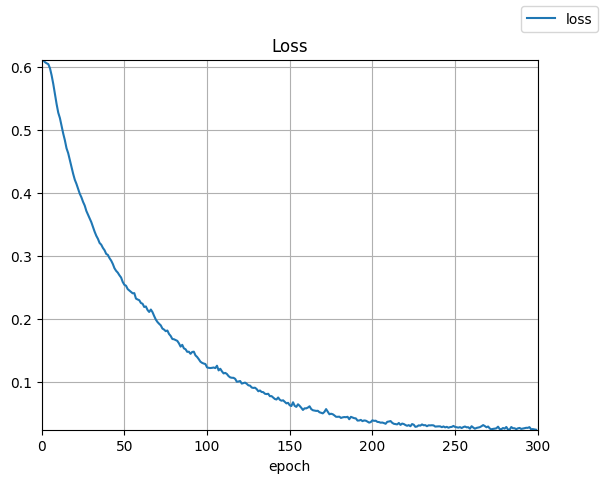

Loss:   0%|          | 0/300 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [ ]:
from naml.modules.sequence import train_seq2seq,EncoderDecoder
from naml.text import Vocabulary

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

from naml.text import flatten
from naml.dataset import Datasets
from naml.dataset.nmt import load_nmt
datasets = Datasets("~/naml-data")
src_words, target_words = load_nmt(datasets, 'cmn', 'eng', max_examples=500)

src_vocab, tgt_vocab = Vocabulary(flatten(src_words)), Vocabulary(flatten(target_words))
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, lr, num_epochs, src_vocab, tgt_vocab, src_words, target_words, batch_size, num_steps)


## Prediction
We need to predict until `<eos>` token is generated - which is not in the target sequences.

In [16]:
from naml.dataset.nmt import nmt_tokenizer
from naml.modules.sequence import predict_seq2seq

for i in range(20,25):
    src = ' '.join(src_words[i])
    tgt = ' '.join(target_words[i])
    src_indices = nmt_tokenizer(src.lower()) + ['<eos>']    
    src_indices = src_vocab.to_indices(src_indices)
    # src_lens = torch.Tensor([len(src_tokens)])
    src_indices = src_vocab.truncate_pad(src_indices, num_steps).long()    
    pred = ' '.join(list(predict_seq2seq(net, src_indices, tgt_vocab, num_steps)))
    print(f"Source\t{src}")
    print(f"Target\t{tgt}")
    print(f"Predict\t{pred}")



Source	i ' m ok .
Target	我沒事。
Predict	我沒事。 我沒事。 我是个男人。 ? ? ? ? 。 。 。
Source	i ' m up .
Target	我已经起来了。
Predict	我已经起来了。 我是个男人。 ? ? ? 。 。 。 。 。
Source	listen .
Target	听着。
Predict	听着。 听着。 听着。 听着。 听着。 听着。 听着。 听着。 听着。 听着。
Source	no way !
Target	不可能！
Predict	不可能！ 她在行走。 ? ? ? ? dj 。 他很忙。 。
Source	no way !
Target	没门！
Predict	不可能！ 她在行走。 ? ? ? ? dj 。 他很忙。 。
